In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

__author__ = 'Song Huang'
__email__ = 'shuang89@ucsc.edu'
__version__ = '170505A'

from __future__ import (print_function, division, absolute_import)

import os
import glob
import copy
import sys
import warnings
import subprocess

import numpy as np
#import seaborn as sns
#sns.set(color_codes=True, style="darkgrid")

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.style.use('classic')
plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

from astropy.io import fits
from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
    
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar

import hsc_massive
from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    smhm, \
    plotting

#envir = s16a_path.set_env(version='astro4')
envir = s16a_path.set_env(version='kungpao')

ORG = plotting.ORG
BLK = plotting.BLK
BLU = plotting.BLU
GRN = plotting.GRN

In [2]:
from kungpao.isophote.ellipse import Ellipse
from kungpao.isophote.ellipse import Centerer
from kungpao.isophote.ellipse import Geometry
from kungpao.isophote.ellipse.model import build_model

# Test data

In [3]:
gal_img = fits.open('redadd_529_HSC-I_full_img.fits')[0].data
gal_bad = fits.open('redadd_529_HSC-I_full_bad.fits')[0].data
gal_sig = fits.open('redadd_529_HSC-I_full_sig.fits')[0].data

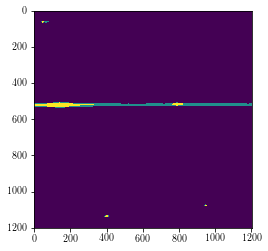

In [4]:
plt.imshow(gal_bad)

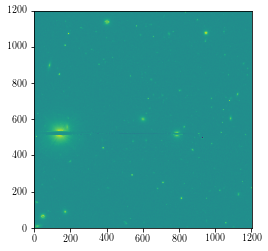

In [5]:
plt.imshow(np.arcsinh(gal_img), origin='lower')

In [6]:
gal_img[gal_bad > 0] = np.nan

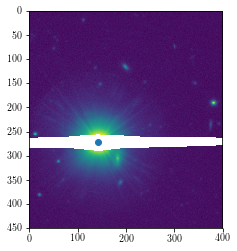

In [7]:
obj1 = gal_img[400:800, 400:800]
obj2 = gal_img[250:700, 0:400]

plt.imshow(np.arcsinh(obj2))
plt.scatter(142, 271)

In [8]:
obj1_geom = Geometry(600.1, 600.1, 4., 0.05, 10./180.*np.pi)
obj1_ellip = Ellipse(obj1, geometry=obj1_geom)

Centering on object....   
Done. Found x0 = 200.0, y0 = 200.0


In [9]:
obj2_geom = Geometry(142.0, 271.0, 10., 0.01, 0.0)
obj2_ellip = Ellipse(obj2, geometry=obj2_geom)

Centering on object....   
Done. Below threshold. Keeping original coordinates.


In [33]:
obj1_isolist = obj1_ellip.fit_image(sma0=1.0, minsma=0.0, maxsma=150.0, 
                                    step=0.15, linear=False, integrmode='median', 
                                    sclip=3., nclip=3, 
                                    conver=0.06, maxit=50, fflag=0.7,
                                    fixgeom=False)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
   1.00       41.18 ( 0.09)  0.069 (0.010) 148.47 ( 4.6)  0.141    13     0   50     2
   1.15       39.83 ( 0.08)  0.079 (0.007) 148.47 ( 2.8)  0.106    13     0   50     2
   1.32       38.18 ( 0.09)  0.082 (0.006) 146.66 ( 2.4)  0.086    13     0   10     0
   1.52       36.00 ( 0.08)  0.079 (0.005) 146.73 ( 2.0)  0.064    13     0   10     0
   1.75       33.38 ( 0.05)  0.070 (0.003) 147.52 ( 1.2)  0.035    13     0   14     0
   2.01       30.56 ( 0.04)  0.076 (0.002) 147.52 ( 0.7)  0.032    13     0   50     2
   2.31       27.61 ( 0.04)  0.088 (0.002) 149.31 ( 0.6)  0.028    14     0   10     0
   2.66       24.25 ( 0.02)  0.086 (0.001) 146.33 ( 0.3)  0.015    16     0   10     0
   3.0

/Users/song/Dropbox/work/project/kungpao/kungpao/isophote/ellipse/sample.py:304: RuntimeWarning: invalid value encountered in greater_equal
  r_intensities.append(intensities[k])
/Users/song/Dropbox/work/project/kungpao/kungpao/isophote/ellipse/sample.py:305: RuntimeWarning: invalid value encountered in less_equal
  


  76.14        0.02 ( 0.00)  0.154 (0.000) 163.17 ( 0.0)  None    118     8    0     4
  87.57        0.01 ( 0.00)  0.154 (0.000) 163.17 ( 0.0)  None    105    21    0     4
 100.70        0.00 ( 0.00)  0.154 (0.000) 163.17 ( 0.0)  None    106    20    0     4
 115.80       -0.00 ( 0.00)  0.154 (0.000) 163.17 ( 0.0)  None    112    14    0     4
 133.18       -0.00 ( 0.00)  0.154 (0.000) 163.17 ( 0.0)  None    111    15    0     4
   0.87       41.66 ( 0.66)  0.154 (0.017) 163.17 ( 3.6)  1.626    13     1    0     4
   0.76       42.37 ( 0.60)  0.154 (0.020) 163.17 ( 4.2)  1.860    13     1    0     4
   0.66       42.97 ( 0.55)  0.154 (0.019) 163.17 ( 4.2)  2.012    13     1    0     4
   0.57       43.50 ( 0.51)  0.154 (0.019) 163.17 ( 4.1)  2.113    13     1    0     4
   0.00       46.08


In [30]:
obj2_isolist = obj2_ellip.fit_image(sma0=40.0, minsma=18.0, maxsma=120.0, 
                                    step=0.10, linear=False, integrmode='median', 
                                    sclip=2.0, nclip=2, 
                                    conver=0.07, maxit=80, fflag=0.8,
                                    fixgeom=True)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
  40.00        6.13 ( 0.06)  0.010 (0.002)   0.00 ( 4.1)  0.057    88    38    0     4
  44.00        4.71 ( 0.05)  0.010 (0.002)   0.00 ( 4.5)  0.059    90    36    0     4
  48.40        3.54 ( 0.04)  0.010 (0.002)   0.00 ( 4.7)  0.066    93    33    0     4
  53.24        2.67 ( 0.04)  0.010 (0.002)   0.00 ( 5.3)  0.068    97    29    0     4
  58.56        1.98 ( 0.03)  0.010 (0.002)   0.00 ( 5.2)  0.061   100    26    0     4
  64.42        1.46 ( 0.02)  0.010 (0.002)   0.00 ( 4.5)  0.047   100    26    0     4
  70.86        1.05 ( 0.01)  0.010 (0.002)   0.00 ( 4.4)  0.047    98    28    0     4
  77.95        0.81 ( 0.01)  0.010 (0.002)   0.00 ( 4.1)  0.054   103    23    0     4
  85.7

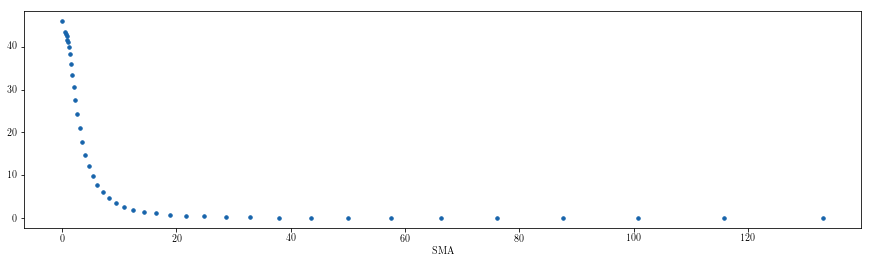

In [34]:
plt.figure(figsize=(15,4))
plt.scatter(obj1_isolist.sma, obj1_isolist.intens, s=12, c=BLU(0.8))
plt.xlabel(r'$\mathrm{SMA}$')

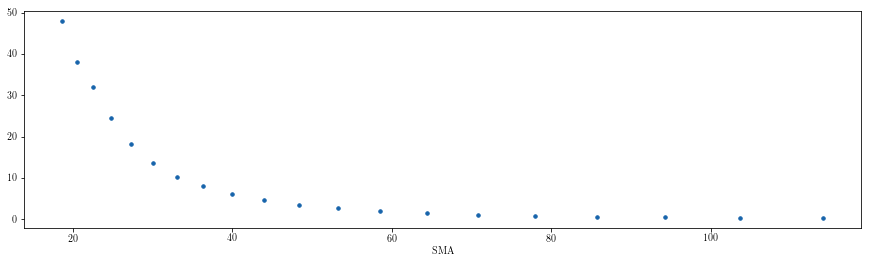

In [31]:
plt.figure(figsize=(15,4))
plt.scatter(obj2_isolist.sma, obj2_isolist.intens, s=12, c=BLU(0.8))
plt.xlabel(r'$\mathrm{SMA}$')

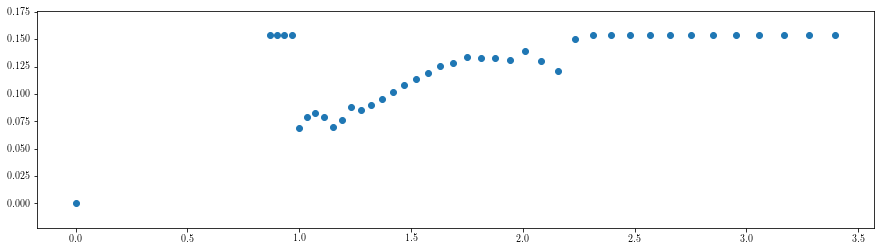

In [22]:
plt.figure(figsize=(15,4))
plt.scatter(obj1_isolist.sma ** 0.25, obj1_isolist.eps)

Interpolating....
Done
SMA=133.1
Done


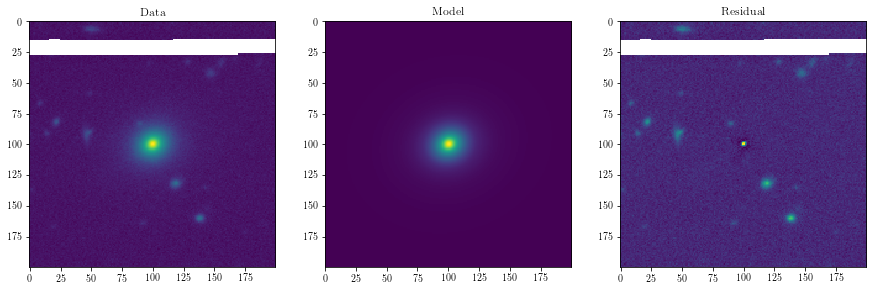

In [23]:
obj1_model = build_model(obj1, obj1_isolist, high_harmonics=False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

ax1.imshow(np.arcsinh(obj1)[100:300, 100:300])
ax1.set_title(r"$\mathrm{Data}$")

ax2.imshow(np.arcsinh(obj1_model)[100:300, 100:300])
ax2.set_title(r"$\mathrm{Model}$")

ax3.imshow(np.arcsinh(obj1 - obj1_model)[100:300, 100:300])
ax3.set_title(r"$\mathrm{Residual}$")

Interpolating....
Done
SMA=114.1
Done


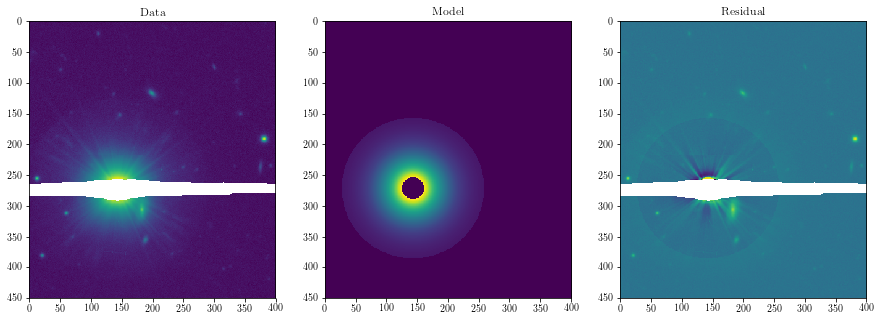

In [32]:
obj2_model = build_model(obj2, obj2_isolist, high_harmonics=False, step=0.3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

ax1.imshow(np.arcsinh(obj2))
ax1.set_title(r"$\mathrm{Data}$")

ax2.imshow(np.arcsinh(obj2_model))
ax2.set_title(r"$\mathrm{Model}$")

ax3.imshow(np.arcsinh(obj2 - obj2_model))
ax3.set_title(r"$\mathrm{Residual}$")

# Test model interpolation

In [132]:
from scipy.interpolate import UnivariateSpline 
from scipy.interpolate import LSQUnivariateSpline

nodes = isolist.sma[2:-2]

finely_spaced_sma = np.arange(isolist[0].sma, isolist[-1].sma, 0.10)

intens = LSQUnivariateSpline(isolist.sma, isolist.intens, nodes)(finely_spaced_sma)
eps    = LSQUnivariateSpline(isolist.sma, isolist.eps,    nodes)(finely_spaced_sma)
pa     = LSQUnivariateSpline(isolist.sma, isolist.pa,     nodes)(finely_spaced_sma)
x0     = LSQUnivariateSpline(isolist.sma, isolist.x0,     nodes)(finely_spaced_sma)
y0     = LSQUnivariateSpline(isolist.sma, isolist.y0,     nodes)(finely_spaced_sma)

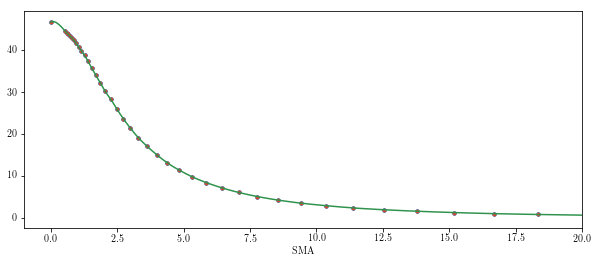

In [133]:
plt.figure(figsize=(10,4))
plt.scatter(isolist2.sma, isolist2.intens, s=12, c=BLU(0.8))
plt.scatter(isolist.sma, isolist.intens, s=8, c=ORG(0.7))
plt.plot(finely_spaced_sma, intens, c=GRN(0.7))
plt.xlim(-1.0, 20.0)
plt.xlabel(r'$\mathrm{SMA}$')

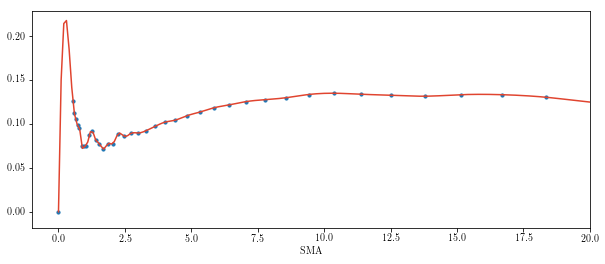

In [134]:
plt.figure(figsize=(10,4))
plt.scatter(isolist.sma, isolist.eps, s=10)
plt.plot(finely_spaced_sma, eps, c=ORG(0.7))
plt.xlim(-1.0, 20.0)
plt.xlabel(r'$\mathrm{SMA}$')